### The purpose is to continue with the results. 

In [1]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']
News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las

# This code will be based on article-level with speech-level analysis. With this cosine similarity will be calculated 

In [2]:
# =====================================================================
# 1. Imports & Initialization
# =====================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Convert and verify date columns
news_embeddings['news_date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['speech_date'] = pd.to_datetime(speeches_embeddings['date'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================================================
# 2. Temporal Pair Generation (Unchanged)
# =====================================================================
def generate_temporal_pairs(news_df, speeches_df, window_days=3):
    """Generate news-speech pairs within temporal window"""
    pairs = []
    chunk_size = 2000
    news_chunks = np.array_split(news_df, len(news_df) // chunk_size + 1)
    
    for chunk in news_chunks:
        for _, row in chunk.iterrows():
            news_date = row['news_date']
            start_date = news_date - pd.Timedelta(days=window_days)
            end_date = news_date  # Only consider speeches before news
            
            mask = (speeches_df['speech_date'] >= start_date) & (speeches_df['speech_date'] <= end_date)
            speech_ids = speeches_df[mask].index.tolist()
            pairs.extend([(row.name, s_id) for s_id in speech_ids])
    
    return pd.DataFrame(pairs, columns=['news_id', 'speech_id'])

alignment_df = generate_temporal_pairs(news_embeddings, speeches_embeddings)

# =====================================================================
# 3. Memory-Optimized Embedding Processing (Unchanged)
# =====================================================================
def load_embeddings_half(df, col_name):
    embeddings = []
    for i, row in df.iterrows():
        if isinstance(row[col_name], str):
            arr = np.fromstring(row[col_name].strip("[]"), sep=" ", dtype=np.float16)
        else:
            arr = np.array(row[col_name], dtype=np.float16)
        embeddings.append(torch.tensor(arr, device=device).half())
        if i % 1000 == 0: torch.cuda.empty_cache()
    return torch.stack(embeddings)

news_tensor = load_embeddings_half(news_embeddings, 'news_embeddings')
speeches_tensor = load_embeddings_half(speeches_embeddings, 'speech_embeddings')

# =====================================================================
# 4. Batched Similarity Computation (Unchanged)
# =====================================================================
def compute_cosine_similarities(pairs_df, news_emb, speech_emb, batch_size=8192):
    news_norm = F.normalize(news_emb, p=2, dim=1)
    speech_norm = F.normalize(speech_emb, p=2, dim=1)
    similarities = []
    for i in range(0, len(pairs_df), batch_size):
        batch = pairs_df.iloc[i:i+batch_size]
        news_batch = news_norm[batch['news_id'].values]
        speech_batch = speech_norm[batch['speech_id'].values]
        similarities.append(F.cosine_similarity(news_batch, speech_batch).cpu().numpy())
        del news_batch, speech_batch
        torch.cuda.empty_cache()
    return np.concatenate(similarities)

alignment_df['cosine_similarity'] = compute_cosine_similarities(alignment_df, news_tensor, speeches_tensor)

# =====================================================================
# 5. Enrich with Temporal Metadata (CORRECTED VERSION)
# =====================================================================
def add_temporal_features(pairs_df, news_df, speeches_df):
    pairs_df = pairs_df.merge(
        news_df[['news_date']],
        left_on='news_id',
        right_index=True
    ).merge(
        speeches_df[['speech_date']],
        left_on='speech_id',
        right_index=True
    )
    pairs_df['days_diff'] = (pairs_df['news_date'] - pairs_df['speech_date']).dt.days
    return pairs_df

enriched_df = add_temporal_features(alignment_df, news_embeddings, speeches_embeddings)

# =====================================================================
# 6. Save Processed Data (Unchanged)
# =====================================================================
enriched_df.to_parquet('news_speech_similarities.parquet', engine='pyarrow', compression='zstd')
print("Processing complete. Results saved with columns:", enriched_df.columns.tolist())

Using device: cuda


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing complete. Results saved with columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff']


In [3]:
print(enriched_df.head(1000))
print(enriched_df.shape)

     news_id  speech_id  cosine_similarity  news_date speech_date  days_diff
0         89     150494           0.246826 2018-12-04  2018-12-04          0
1         89     150495           0.246826 2018-12-04  2018-12-04          0
2         89     150496           0.246826 2018-12-04  2018-12-04          0
3         89     150497           0.246826 2018-12-04  2018-12-04          0
4         89     150498           0.246826 2018-12-04  2018-12-04          0
..       ...        ...                ...        ...         ...        ...
995       99     150556           0.305420 2018-12-05  2018-12-04          1
996       99     150557           0.305420 2018-12-05  2018-12-04          1
997       99     150558           0.305420 2018-12-05  2018-12-04          1
998       99     150559           0.305420 2018-12-05  2018-12-04          1
999       99     150560           0.305420 2018-12-05  2018-12-04          1

[1000 rows x 6 columns]
(14254971, 6)


Data types:
 news_id                       int64
speech_id                     int64
cosine_similarity           float32
news_date            datetime64[ns]
speech_date          datetime64[ns]
days_diff                     int64
dtype: object


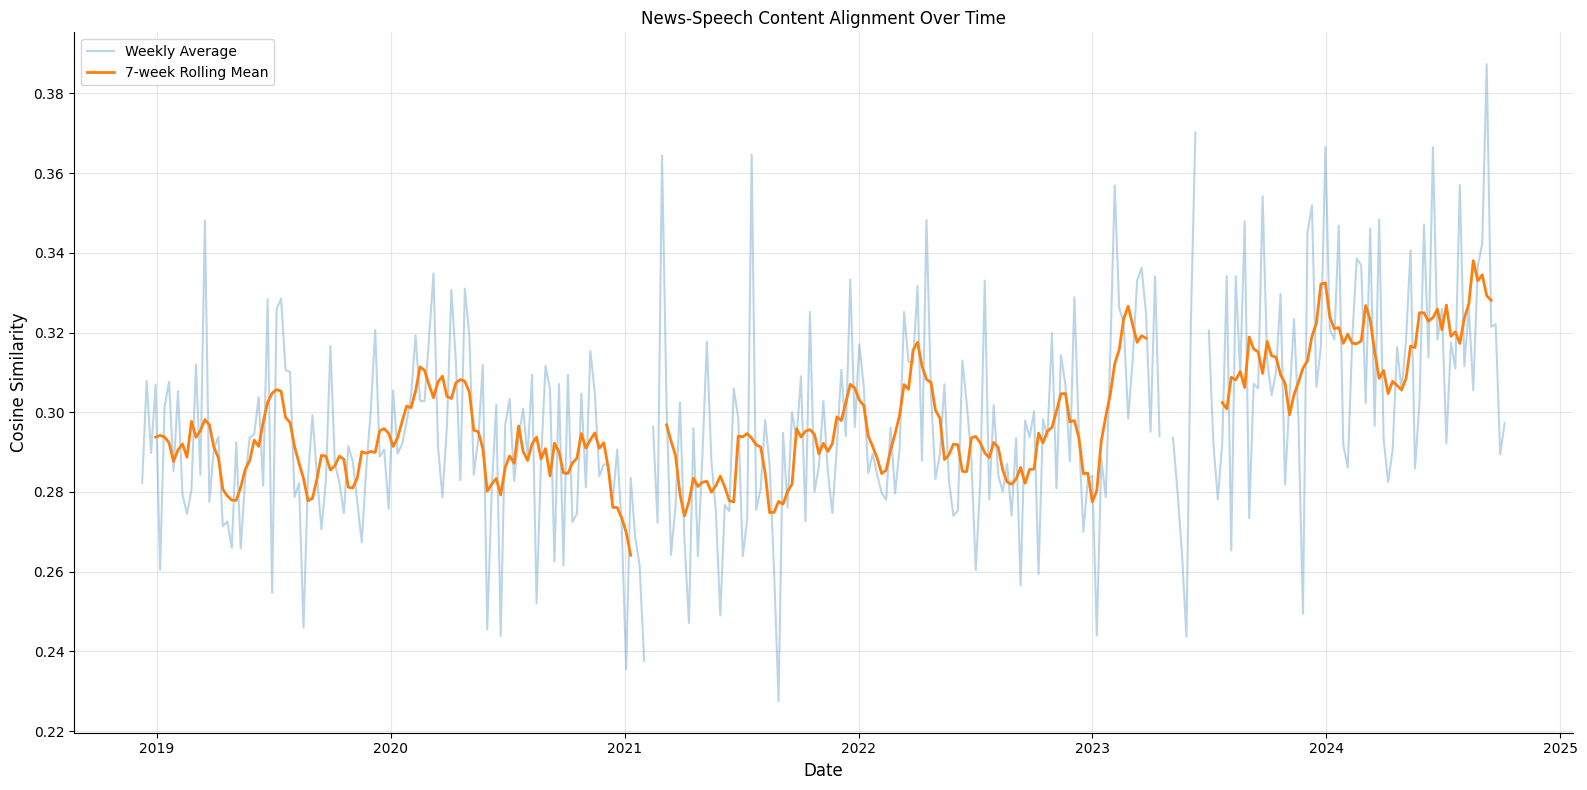

In [5]:
# =====================================================================
# 1. Imports & Data Loading (MODIFIED)
# =====================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_safe_data():
    """Load data with proper dtype conversions"""
    df = pd.read_parquet('news_speech_similarities.parquet').astype({
        'news_id': 'int64',
        'speech_id': 'int64',
        'cosine_similarity': 'float32'  # Convert from float16 to float32
    })
    df['news_date'] = pd.to_datetime(df['news_date'])
    return df

# Load processed data
df = load_safe_data()

# =====================================================================
# 2. Temporal Trend Analysis (FIXED VERSION)
# =====================================================================
def plot_temporal_trends(df, resample_freq='W', rolling_window=7):
    """Plot similarity trends with type-safe processing"""
    plt.figure(figsize=(16, 8))
    
    # Ensure float32 type
    temp_df = df[['news_date', 'cosine_similarity']].copy()
    temp_df['cosine_similarity'] = temp_df['cosine_similarity'].astype('float32')
    
    # Resample data
    df_temp = temp_df.set_index('news_date')
    resampled = df_temp['cosine_similarity'].resample(resample_freq).mean()
    
    # Create rolling average
    rolling_mean = resampled.rolling(window=rolling_window, center=True).mean()
    
    # Plot with enhanced formatting
    plt.plot(resampled.index, resampled.values, 
            alpha=0.3, label='Weekly Average')
    plt.plot(rolling_mean.index, rolling_mean.values,
            linewidth=2, label=f'{rolling_window}-week Rolling Mean')
    
    plt.title('News-Speech Content Alignment Over Time')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cosine Similarity', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

# =====================================================================
# 3. Execution (MODIFIED)
# =====================================================================
if __name__ == "__main__":
    df = load_safe_data()
    
    # Verify data types
    print("Data types:\n", df.dtypes)
    
    # Plot temporal trends only
    plot_temporal_trends(df)

In [7]:
import re

def extract_outlet(url):
    """Extract outlet name from URL with improved pattern matching"""
    patterns = [
        r"https?://(?:www\.)?([^/.]+)\.",
        r"https?://([^/]+)/",
        r"([a-z0-9-]+)\.(com|org|net|edu|gov)"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, url, re.IGNORECASE)
        if match:
            return match.group(1).lower()
    return "unknown"

# Add outlet column to news_embeddings
news_embeddings['outlet'] = news_embeddings['Link'].apply(extract_outlet)

In [8]:
print("News embeddings columns:", news_embeddings.columns.tolist())
print("Sample outlets:", news_embeddings['outlet'].unique()[:10])

News embeddings columns: ['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr', 'processed_content', 'news_chunks', 'news_embeddings', 'news_date', 'outlet']
Sample outlets: ['bbc' 'politica' 'oem' 'eleconomista' 'milenio' 'eluniversal' 'latercera'
 'informador' 'perfil' 'nacion321']


In [9]:
# =====================================================================
# 1. Imports & Data Loading
# =====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from math import pi

# Set data paths
DATA_DIR = '/kaggle/input/embeddings'  # Update this to your data directory
NEWS_PATH = os.path.join(DATA_DIR, 'news_with_embeddings.csv')
SPEECHES_PATH = os.path.join(DATA_DIR, 'speeches_with_embeddings.csv')
SIMILARITIES_PATH = 'news_speech_similarities.parquet'

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


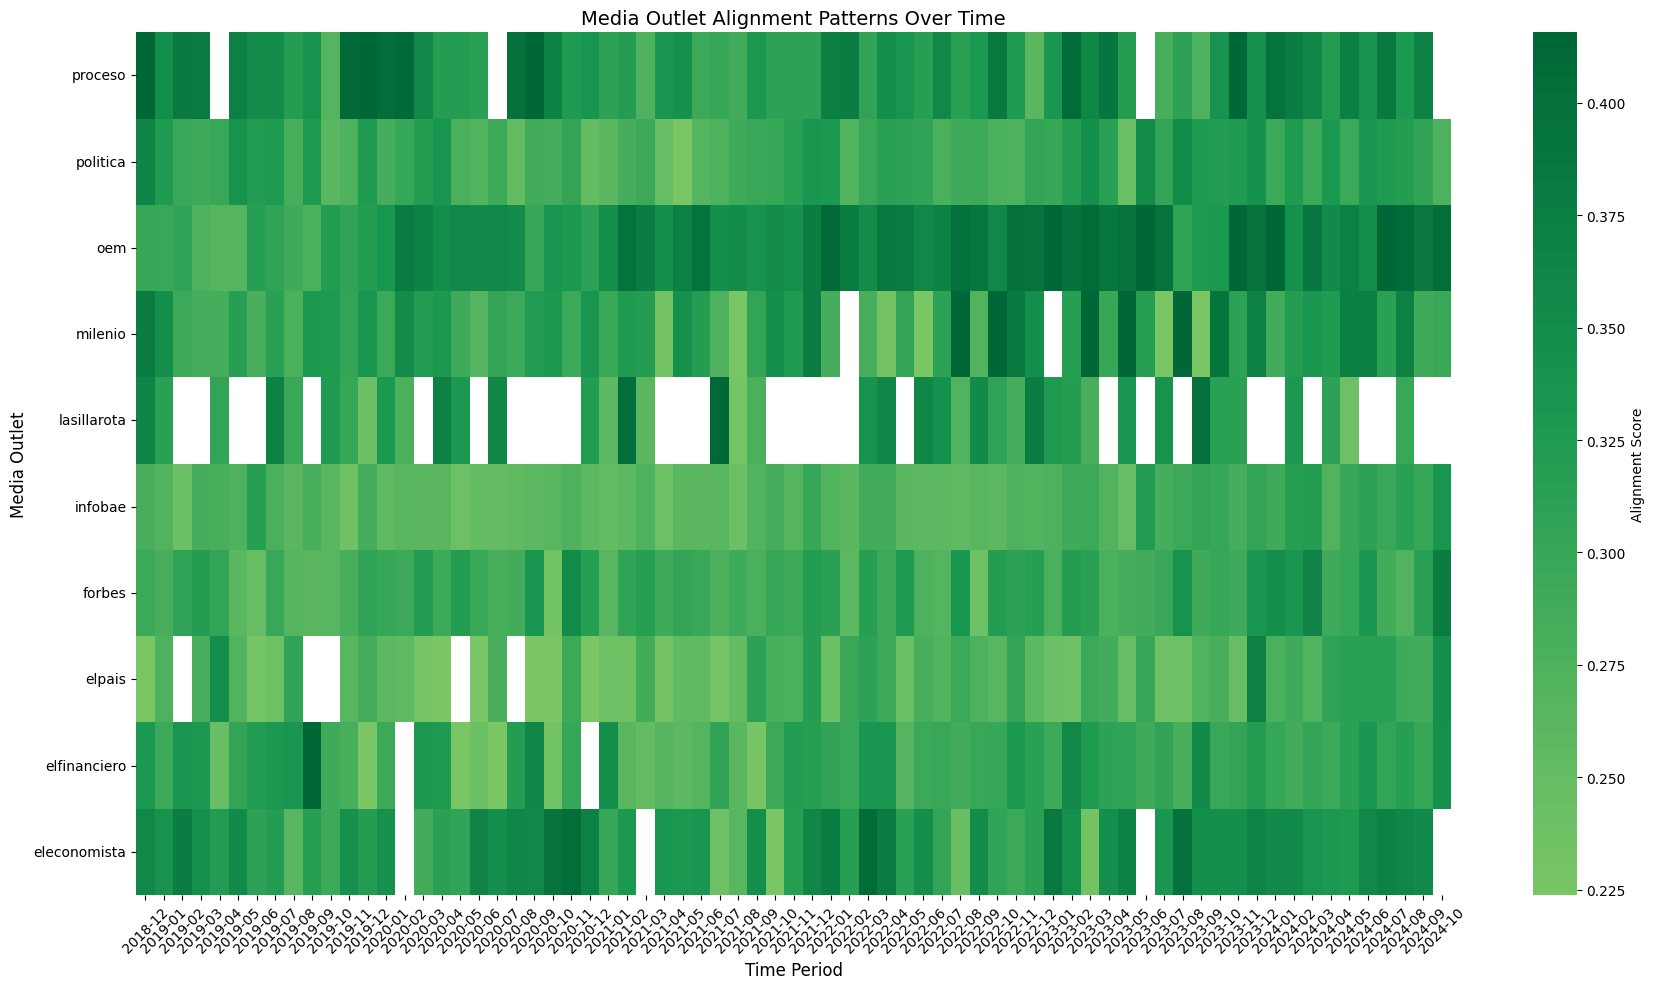

In [10]:

# =====================================================================
# 2. Helper Functions
# =====================================================================
def extract_outlet(url):
    """Extract outlet name from URL"""
    patterns = [
        r"https?://(?:www\.)?([^/.]+)\.",
        r"https?://([^/]+)/",
        r"([a-z0-9-]+)\.(com|org|net|edu|gov)"
    ]
    for pattern in patterns:
        match = re.search(pattern, url, re.IGNORECASE)
        if match:
            return match.group(1).lower()
    return "unknown"
    
def load_data():
    """Load data with path validation"""
    if not os.path.exists(NEWS_PATH):
        raise FileNotFoundError(f"News data not found at {NEWS_PATH}")
    if not os.path.exists(SPEECHES_PATH):
        raise FileNotFoundError(f"Speeches data not found at {SPEECHES_PATH}")
    if not os.path.exists(SIMILARITIES_PATH):
        raise FileNotFoundError(f"Similarity data not found at {SIMILARITIES_PATH}")

    news_df = pd.read_csv(NEWS_PATH)
    speeches_df = pd.read_csv(SPEECHES_PATH)
    similarities_df = pd.read_parquet(SIMILARITIES_PATH)
    
    return news_df, speeches_df, similarities_df

# 3. Visualization Functions (CORRECTED)
# =====================================================================
def plot_temporal_alignment_heatmap(df, news_metadata, resample_freq='M'):
    """Show outlet-specific alignment patterns over time"""
    # Define required columns as LISTS not sets
    required_main = ['news_id', 'news_date', 'cosine_similarity']
    required_news = ['news_id', 'outlet']
    
    # Check missing columns using set operations
    missing_main = list(set(required_main) - set(df.columns))
    if missing_main:
        raise ValueError(f"Main data missing: {missing_main}")
    
    missing_news = list(set(required_news) - set(news_metadata.columns))
    if missing_news:
        raise ValueError(f"News metadata missing: {missing_news}")

    # Merge data using list-based column selection
    merged_df = df[required_main].merge(
        news_metadata[required_news],
        on='news_id',
        how='inner'
    )
    
    # Rest of the function remains the same...
    merged_df['period'] = merged_df['news_date'].dt.to_period(resample_freq)
    pivot_data = merged_df.groupby(['outlet', 'period'])['cosine_similarity'].mean().unstack()

    # Filter and sort top outlets
    top_outlets = merged_df['outlet'].value_counts().head(10).index
    pivot_data = pivot_data.loc[top_outlets.sort_values(ascending=False)]

    #color grid
    custom_cmap = sns.light_palette("#ff0000", as_cmap=True)
    
    # Plot heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(
        pivot_data,
        cmap='RdYlGn',
        center=0.0,
        robust=True,
        cbar_kws={'label': 'Alignment Score'}
    )
    plt.title('Media Outlet Alignment Patterns Over Time', fontsize=14)
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('Media Outlet', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def plot_alignment_variability_radar(df, news_metadata):
    """Compare outlets across multiple alignment dimensions"""
    # Merge data
    merged_df = df.merge(
        news_metadata[['news_id', 'outlet']],
        on='news_id',
        how='inner'
    )
    
    # Calculate metrics
    metrics = merged_df.groupby('outlet')['cosine_similarity'].agg(
        ['mean', 'std', lambda x: x.quantile(0.75) - x.quantile(0.25)]
    ).rename(columns={'<lambda_0>': 'iqr'})
    
    # Normalize metrics
    metrics_norm = metrics.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # Plot setup
    categories = metrics_norm.columns.tolist()
    N = len(categories)
    angles = [n / N * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, polar=True)

    # Plot each outlet
    for outlet in metrics_norm.index:
        values = metrics_norm.loc[outlet].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, label=outlet)
        ax.fill(angles, values, alpha=0.1)

    # Formatting
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.yaxis.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Outlet Alignment Profile Comparison', pad=40)
    plt.show()

# =====================================================================
# =====================================================================
# 5. Execution Block (VERIFIED)
# =====================================================================
if __name__ == "__main__":
    try:
        # Load data with validated paths
        news_data, speeches_data, similarity_data = load_data()
        
        # Add outlet information
        news_data['outlet'] = news_data['Link'].apply(extract_outlet)
        news_metadata = news_data.reset_index().rename(columns={'index': 'news_id'})
        
        # Generate visualizations with list-based columns
        plot_temporal_alignment_heatmap(
            similarity_data,
            news_metadata,
            resample_freq='M'
        )
        
    except Exception as e:
        print(f"Execution Error: {str(e)}")
        print("Common fixes:")
        print("1. Verify column names in input files")
        print("2. Check data merging logic")
        print("3. Validate datetime formatting")

<ipython-input-11-f636a72d456b>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['period'] = filtered_df['news_date'].dt.to_period(resample_freq)


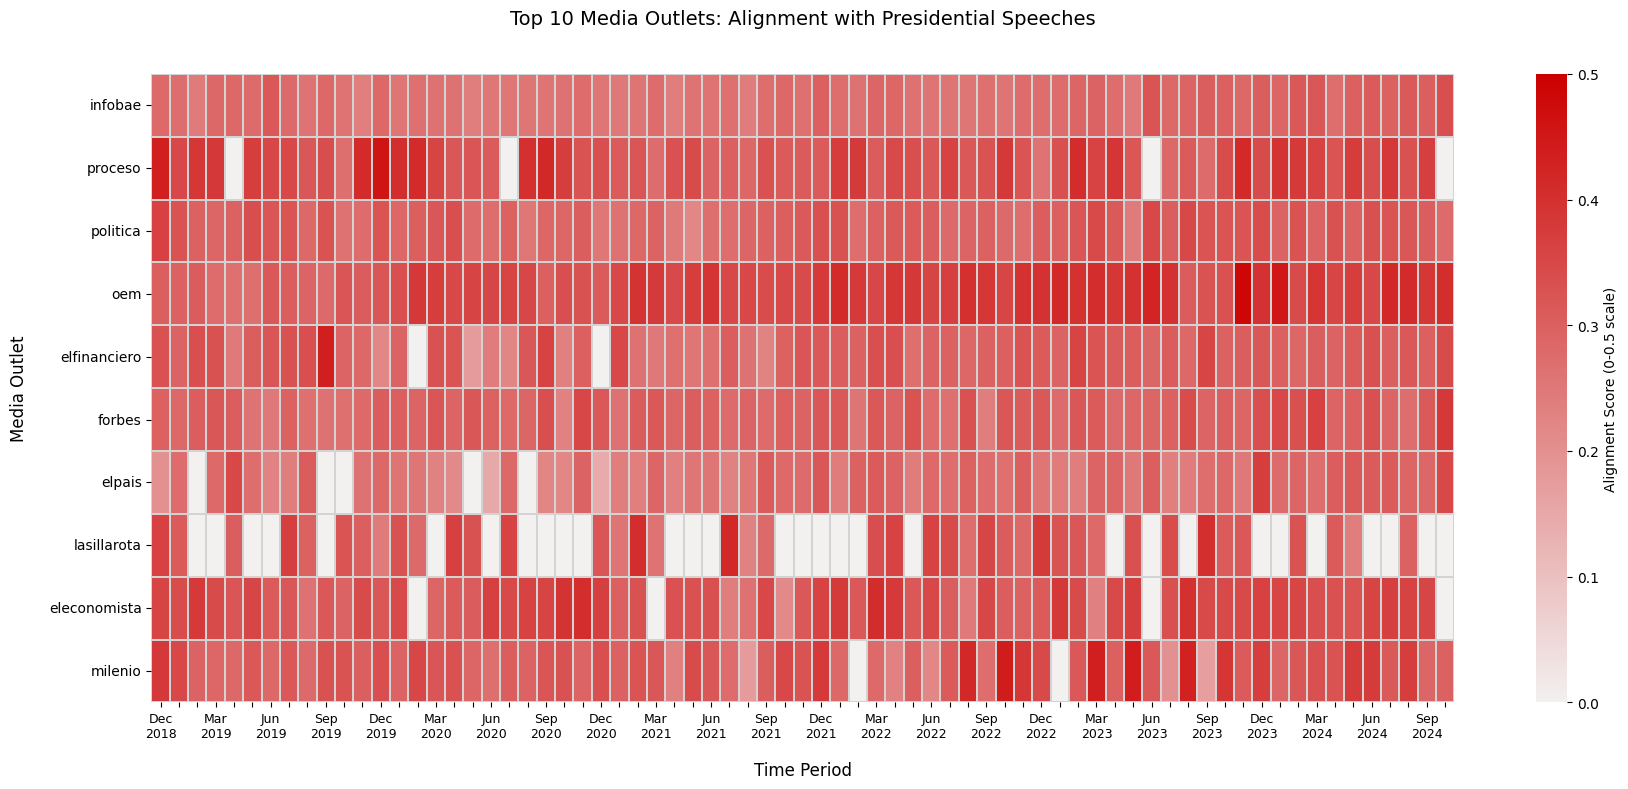

In [11]:
# =====================================================================
# 1. Imports & Configuration
# =====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from matplotlib.colors import Normalize



# 2. Helper Function: Extract Outlet from URL
# =====================================================================
def extract_outlet(url):
    """Extract media outlet name from news article URL"""
    patterns = [
        r"https?://(?:www\.)?([^/.]+)\.",
        r"https?://([^/]+)/",
        r"([a-z0-9-]+)\.(com|org|net|edu|gov)"
    ]
    for pattern in patterns:
        match = re.search(pattern, url, re.IGNORECASE)
        if match:
            return match.group(1).lower()
    return "unknown"

# =====================================================================
# 3. Core Heatmap Visualization Function
# =====================================================================
def plot_temporal_alignment_heatmap(df, news_metadata, resample_freq='M'):
    """Show alignment patterns for top 10 outlets"""
    # Merge data and clean
    merged_df = df.merge(
        news_metadata[['news_id', 'outlet']],
        on='news_id',
        how='inner'
    ).dropna(subset=['cosine_similarity'])
    
    # Get top 10 outlets by article count
    top_outlets = merged_df.groupby('outlet')['news_id'].nunique() \
                          .nlargest(10).index.tolist()
    
    # Filter to top outlets only
    filtered_df = merged_df[merged_df['outlet'].isin(top_outlets)]
    
    # Prepare temporal data
    filtered_df['period'] = filtered_df['news_date'].dt.to_period(resample_freq)
    pivot_data = filtered_df.groupby(['outlet', 'period'])['cosine_similarity'] \
                          .mean().unstack().fillna(0)
    
    # Sort outlets by total articles (descending)
    outlet_order = filtered_df.groupby('outlet')['news_id'].nunique() \
                             .sort_values(ascending=False).index
    pivot_data = pivot_data.loc[outlet_order]
    
    # Fixed sizing for 10 outlets
    plt.figure(figsize=(18, 8))  # Width 18", Height 8"
    
    # Plot heatmap
    ax = sns.heatmap(
        pivot_data,
        cmap=sns.light_palette("#cc0000", as_cmap=True),
        norm=Normalize(vmin=0, vmax=0.5),
        linewidths=0.3,
        linecolor='lightgray',
        cbar_kws={'label': 'Alignment Score (0-0.5 scale)'}
    )
    
    # Formatting
    ax.set_title('Top 10 Media Outlets: Alignment with Presidential Speeches\n', pad=20, fontsize=14)
    ax.set_xlabel('Time Period', labelpad=15, fontsize=12)
    ax.set_ylabel('Media Outlet', labelpad=15, fontsize=12)
    ax.set_xticklabels(
        [col.strftime('%b\n%Y') if i%3==0 else '' for i, col in enumerate(pivot_data.columns)],
        rotation=0,
        fontsize=9
    )
    plt.tight_layout()
    plt.show()
# =====================================================================
# 4. Execution Block
# =====================================================================
if __name__ == "__main__":
    try:
        # Load data
        news_df = pd.read_csv(NEWS_PATH)
        similarities_df = pd.read_parquet(SIMILARITIES_PATH)
        
        # Add outlet information
        news_df['outlet'] = news_df['Link'].apply(extract_outlet)
        news_metadata = news_df[['outlet']].reset_index().rename(columns={'index': 'news_id'})
        
        # Generate visualization
        plot_temporal_alignment_heatmap(
            similarities_df,
            news_metadata,
            resample_freq='M'  # Monthly aggregation
        )
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Troubleshooting steps:")
        print(f"1. Verify files exist in: {DATA_DIR}")
        print(f"2. Check file contents: {os.listdir(DATA_DIR)}")
        print("3. Confirm required columns exist in dataframes")

<ipython-input-13-d9965db0d1e4>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().reset_index()


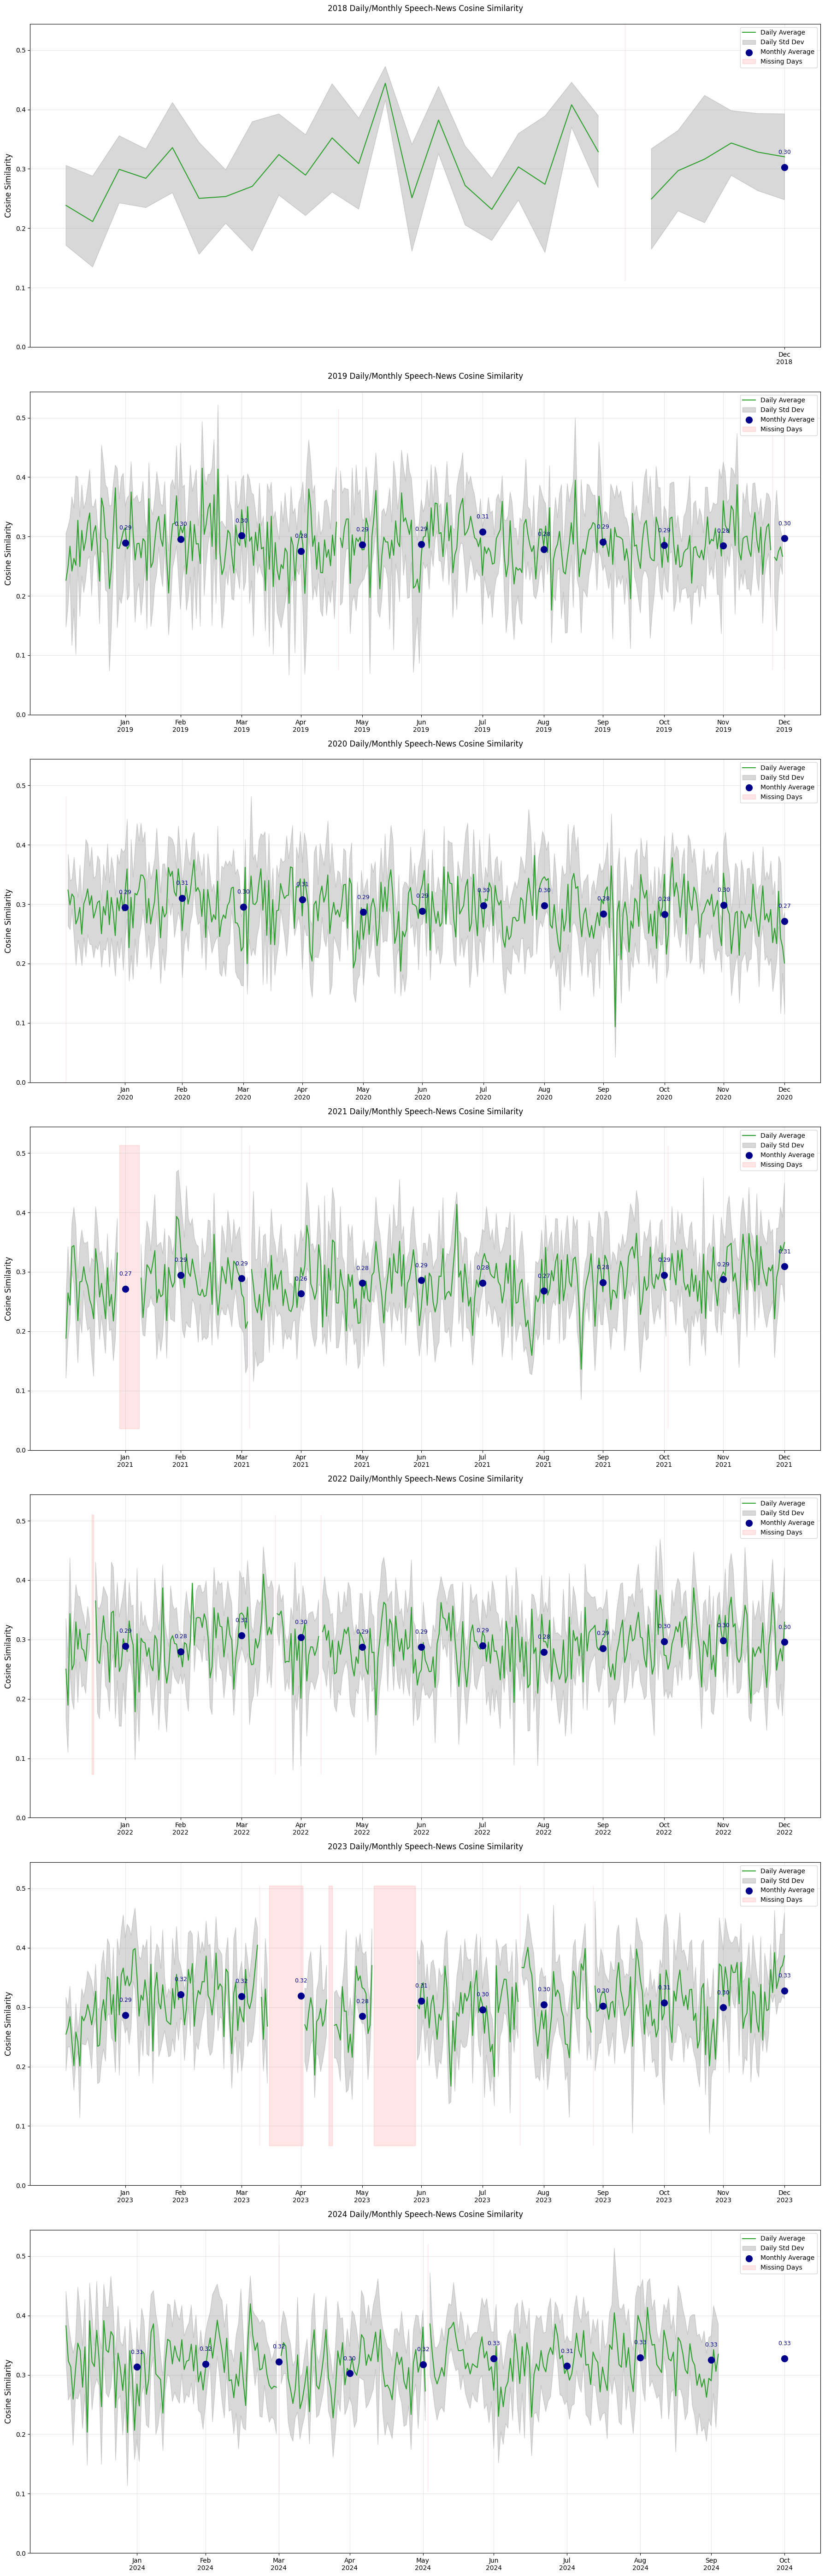

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load processed data
df = pd.read_parquet('news_speech_similarities.parquet')

# Convert to datetime and extract year
df['news_date'] = pd.to_datetime(df['news_date'])
df['year'] = df['news_date'].dt.year

# Create daily aggregates with std dev
daily_agg = df.groupby('news_date')['cosine_similarity'].agg(['mean', 'std']).reset_index()
daily_agg.columns = ['date', 'cosine_similarity', 'std_dev']

# Create full date range for missing data handling
full_dates = pd.date_range(start=daily_agg['date'].min(), end=daily_agg['date'].max(), freq='D')
daily_agg = daily_agg.set_index('date').reindex(full_dates).reset_index().rename(columns={'index': 'date'})

# Calculate bounds
daily_agg['upper_bound'] = daily_agg['cosine_similarity'] + daily_agg['std_dev']
daily_agg['lower_bound'] = daily_agg['cosine_similarity'] - daily_agg['std_dev']

# Create monthly aggregates for secondary axis
monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().reset_index()
monthly_agg['month_label'] = monthly_agg['date'].dt.strftime('%b\n%Y')

# Get unique years present in data
years = daily_agg['date'].dt.year.unique()

# Set up plot
plt.figure(figsize=(18, 8 * len(years)))

for i, year in enumerate(years, 1):
    year_mask = daily_agg['date'].dt.year == year
    yearly_daily = daily_agg[year_mask]
    yearly_monthly = monthly_agg[monthly_agg['date'].dt.year == year]
    
    if yearly_daily.empty:
        continue
    
    ax = plt.subplot(len(years), 1, i)
    
    # Daily plot with variability
    ax.plot(yearly_daily['date'], 
            yearly_daily['cosine_similarity'], 
            color='#2ca02c', 
            linewidth=1.5,
            label='Daily Average')
    
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['upper_bound'],
                    yearly_daily['lower_bound'],
                    color='gray', alpha=0.3, 
                    label='Daily Std Dev')
    
    # Monthly markers
    ax.scatter(yearly_monthly['date'], 
               yearly_monthly['cosine_similarity'],
               color='darkblue', 
               s=100,
               zorder=5,
               label='Monthly Average')
    
    # Annotate monthly values
    for _, row in yearly_monthly.iterrows():
        ax.text(row['date'], row['cosine_similarity']+0.02,
                f"{row['cosine_similarity']:.2f}",
                ha='center', va='bottom',
                fontsize=9, color='darkblue')
    
    # Highlight missing days
    missing_mask = yearly_daily['cosine_similarity'].isna()
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['cosine_similarity'].min() - 0.1,
                    yearly_daily['cosine_similarity'].max() + 0.1,
                    where=missing_mask,
                    color='red', alpha=0.1,
                    label='Missing Days')
    
    # Formatting
    ax.set_title(f'{year} Daily/Monthly Speech-News Cosine Similarity', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set monthly x-ticks
    ax.set_xticks(yearly_monthly['date'])
    ax.set_xticklabels(yearly_monthly['month_label'])
    
    # Set y-axis limits
    y_min = max(daily_agg['cosine_similarity'].min() - 0.1, 0)
    y_max = min(daily_agg['cosine_similarity'].max() + 0.1, 1)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Statistical analysis 
Im missing solving second error in 2024 graph 

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create speech presence indicator (1 if any speech occurred in past N days)
df['speech_present'] = df.groupby('date')['speech_id'].transform(lambda x: x.notna().astype(int))

# Run fixed effects regression
model = ols(
    formula='cosine_similarity ~ speech_present + speech_length + C(outlet) + C(date)',
    data=df
).fit(cov_type='cluster', cov_kwds={'groups': df['outlet']})

print(model.summary())

KeyError: 'date'

# This analysis is based on article_chunk level daily average score, paired with speech chunks on a daily basis. 

In [ ]:
# =====================================================================
# 1. Imports & Initialization
# =====================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# =====================================================================
# 2. Data Preparation & Date Alignment
# =====================================================================
def align_dates(news_df, speeches_df):
    """Filter and align dates between news and speeches across all years"""
    # Find common dates across the full dataset
    common_dates = set(news_df['Date']).intersection(set(speeches_df['date']))
    
    return (
        news_df[news_df['Date'].isin(common_dates)].reset_index(drop=True),
        speeches_df[speeches_df['date'].isin(common_dates)].reset_index(drop=True),
        sorted(common_dates)  # Sorted for consistency
    )

news_data, speeches_data, common_dates = align_dates(news_embeddings, speeches_embeddings)

# =====================================================================
# 3. GPU-Optimized Embedding Processing
# =====================================================================
def process_embeddings(df, col_name):
    """Convert text-based or list embeddings to GPU tensors"""
    embeddings = []
    for row in df[col_name]:
        if isinstance(row, str):
            arr = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
        elif isinstance(row, list):
            arr = np.array(row, dtype=np.float32)
        embeddings.append(torch.tensor(arr, device=device))
    return torch.stack(embeddings)

news_tensor = process_embeddings(news_data, 'news_embeddings')
speeches_tensor = process_embeddings(speeches_data, 'speech_embeddings')

# =====================================================================
# 4. Same-Day Cosine Similarity Calculation
# =====================================================================
def compute_daily_similarities(news_tensor, speeches_tensor, dates, news_df, speeches_df):
    """Compute cosine similarity per date between news and speeches"""
    # Normalize embeddings
    news_norm = F.normalize(news_tensor, p=2, dim=1)
    speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Map dates to indices
    unique_dates = sorted(dates)
    date_indices = {date: i for i, date in enumerate(unique_dates)}
    
    # Initialize result tensors
    daily_avg = torch.zeros(len(unique_dates), device=device)
    daily_std = torch.zeros(len(unique_dates), device=device)
    
    # Compute daily cosine similarity
    for date in unique_dates:
        news_mask = news_df['Date'] == date
        speech_mask = speeches_df['date'] == date
        
        if news_mask.any() and speech_mask.any():
            sim_matrix = torch.mm(news_norm[news_mask], speeches_norm[speech_mask].T)
            daily_avg[date_indices[date]] = sim_matrix.mean()
            daily_std[date_indices[date]] = sim_matrix.std()
    
    return daily_avg.cpu().numpy(), daily_std.cpu().numpy(), unique_dates

daily_scores, daily_stds, valid_dates = compute_daily_similarities(
    news_tensor, speeches_tensor, common_dates, news_data, speeches_data
)

# =====================================================================
# 5. Result Compilation & Handling Missing Data
# =====================================================================
# Create a complete date range across all available years
start_date, end_date = min(common_dates), max(common_dates)
full_dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Build a DataFrame with results
daily_avg_df = pd.DataFrame({
    'date': valid_dates,
    'cosine_similarity': daily_scores,
    'std_dev': daily_stds
})

# Merge with full date range
final_df = pd.DataFrame({'date': full_dates}).merge(
    daily_avg_df, 
    on='date', 
    how='left'
)

# Fill missing values using forward-fill with a 3-day limit
final_df['cosine_similarity'] = final_df['cosine_similarity'].ffill(limit=3)
final_df['std_dev'] = final_df['std_dev'].ffill(limit=3)

# =====================================================================
# 6. Create Bounds for Standard Deviation
# =====================================================================
final_df['upper_bound'] = final_df['cosine_similarity'] + final_df['std_dev']
final_df['lower_bound'] = final_df['cosine_similarity'] - final_df['std_dev']

# Save the processed data for later plotting
final_df.to_csv("cosine_similarity_results_all_years.csv", index=False)

print("Processing complete. Data saved for plotting.")


In [ ]:
import matplotlib.pyplot as plt

# Define the years to plot
years = range(2019, 2025)

# Set up the figure size
plt.figure(figsize=(14, 7 * len(years)))

for i, year in enumerate(years, 1):
    yearly_df = final_df[final_df['date'].dt.year == year]
    
    if yearly_df.empty:
        continue  # Skip empty years
    
    plt.subplot(len(years), 1, i)  # Create a subplot for each year
    
    plt.plot(yearly_df['date'], 
             yearly_df['cosine_similarity'], 
             color='#2ca02c', 
             linewidth=1.5,
             marker='o',
             markersize=4,
             label='Cosine Similarity')

    # Plot the upper and lower bounds for 1 standard deviation
    plt.fill_between(yearly_df['date'], 
                     yearly_df['upper_bound'], 
                     yearly_df['lower_bound'], 
                     color='gray', alpha=0.3, label='1 Std Dev Range')

    # Highlight missing data in red
    missing_mask = yearly_df['cosine_similarity'].isna()
    plt.fill_between(yearly_df['date'], 
                     yearly_df['cosine_similarity'], 
                     where=missing_mask,
                     color='red', 
                     alpha=0.1,
                     label='Missing Data')

    # Formatting
    plt.title(f'{year} Daily Average Speech-News Cosine Similarity')
    plt.xlabel('Date')
    plt.ylabel('Cosine Similarity')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(speeches_embeddings.columns)
print(news_embeddings.columns)

# maybe we would also need a regression here before doing topic modelling 

#### Steps: identify top outlets, then I can do basic regressions. 

In [ ]:
import re
import pandas as pd

def extract_outlet(url):
    """Extracts the outlet name from a URL.
    
    Example: 'https://www.eluniversal.com.mx/...'
    returns 'eluniversal'
    """
    if pd.isnull(url):
        return None
    # Use regex to extract text after "www." until the next dot.
    match = re.search(r"www\.([^.]+)", url)
    if match:
        return match.group(1)
    # Fallback: split the URL by '/' and take the domain part
    parts = url.split('/')
    if len(parts) > 2:
        domain = parts[2]
        # Remove any 'www.' if present
        return domain.replace("www.", "")
    return url

# Apply the function to the "Link" column and create a new column "outlet"
news_embeddings['outlet'] = news_embeddings['Link'].apply(extract_outlet)

# Display the first few rows to verify
print(news_embeddings[['Link', 'outlet']].head(10))
print(news_embeddings[['outlet']].head(10))

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# --- Step 0: Standardize Date Columns and Ensure Outlet Information ---
# Rename the date column in news_data to lowercase 'date'
news_data = news_data.rename(columns={'Date': 'date'})

# Ensure 'date' is datetime
news_data['date'] = pd.to_datetime(news_data['date'])
speeches_data['date'] = pd.to_datetime(speeches_data['date'])

# If not already done, extract outlet names from the "Link" column in news_data
import re
def extract_outlet(url):
    if pd.isnull(url):
        return None
    match = re.search(r"www\.([^.]+)", url)
    if match:
        return match.group(1)
    parts = url.split('/')
    if len(parts) > 2:
        return parts[2].replace("www.", "")
    return url

if 'outlet' not in news_data.columns:
    news_data['outlet'] = news_data['Link'].apply(extract_outlet)

# --- Step 1: Identify Top Outlets ---
top_outlets = news_data['outlet'].value_counts().head(10).index.tolist()
print("Top outlets:", top_outlets)

# --- Step 2: Helper Function to Convert Embedding Strings ---
def str_to_array(x):
    """Convert a string representation of an embedding into a numpy array."""
    try:
        return np.fromstring(x.strip("[]"), sep=" ", dtype=np.float32)
    except Exception as e:
        print("Error converting embedding:", e)
        return None

# --- Step 3: Compute Outlet-Level Daily Cosine Similarity ---
outlet_results = []  # To store results for each outlet

for outlet in top_outlets:
    # Filter news_data for the current outlet
    news_outlet = news_data[news_data['outlet'] == outlet].copy()
    # Get unique dates when this outlet published articles
    outlet_dates = sorted(news_outlet['date'].unique())
    daily_sims = []  # store daily cosine similarity for this outlet

    for d in outlet_dates:
        # Filter news articles for this outlet on date d
        news_d = news_outlet[news_outlet['date'] == d]
        # Filter speeches for the same date from speeches_data
        speeches_d = speeches_data[speeches_data['date'] == d]
        
        # Proceed only if we have at least one article and one speech for the day
        if len(news_d) == 0 or len(speeches_d) == 0:
            continue
        
        # Convert news embeddings for the day to numpy arrays
        news_emb_list = news_d['news_embeddings'].apply(str_to_array).tolist()
        speeches_emb_list = speeches_d['speech_embeddings'].apply(str_to_array).tolist()
        
        # If any conversion fails, skip this date
        if any(x is None for x in news_emb_list) or any(x is None for x in speeches_emb_list):
            continue
        
        try:
            # Stack the arrays to form 2D arrays
            news_embeds = np.stack(news_emb_list)
            speeches_embeds = np.stack(speeches_emb_list)
            
            # Convert to torch tensors on GPU
            news_tensor = torch.tensor(news_embeds, device=device)
            speeches_tensor = torch.tensor(speeches_embeds, device=device)
            
            # Normalize embeddings
            news_norm = F.normalize(news_tensor, p=2, dim=1)
            speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
            
            # Compute cosine similarity matrix
            sim_matrix = torch.mm(news_norm, speeches_norm.t())
            daily_sim = sim_matrix.mean().item()
            daily_sims.append(daily_sim)
        except Exception as e:
            print(f"Error for outlet {outlet} on date {d}: {e}")
            continue

    if daily_sims:
        avg_sim = np.mean(daily_sims)
        std_sim = np.std(daily_sims)
    else:
        avg_sim = np.nan
        std_sim = np.nan
    
    outlet_results.append({
        'outlet': outlet,
        'avg_cosine_similarity': avg_sim,
        'std_cosine_similarity': std_sim,
        'num_days': len(daily_sims)
    })

# --- Step 4: Create a DataFrame for Outlet-Level Results ---
outlet_sim_df = pd.DataFrame(outlet_results)
print(outlet_sim_df)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

# Standardize date columns
news_data = news_data.rename(columns={'Date': 'date'})
news_data['date'] = pd.to_datetime(news_data['date'])
speeches_data['date'] = pd.to_datetime(speeches_data['date'])

# Identify top outlets (e.g., top 10) based on article counts in the 'outlet' column
top_outlets = news_data['outlet'].value_counts().head(10).index.tolist()
print("Top outlets:", top_outlets)

# Helper function to convert a string embedding to a numpy array
def str_to_array(x):
    try:
        return np.fromstring(x.strip("[]"), sep=" ", dtype=np.float32)
    except Exception as e:
        print("Error converting embedding:", e)
        return None

# List to store disaggregated daily results for each outlet
daily_outlet_list = []

# Loop over each top outlet
for outlet in top_outlets:
    # Filter news data for the current outlet
    news_outlet = news_data[news_data['outlet'] == outlet].copy()
    # Get unique dates for which this outlet published articles
    unique_dates = sorted(news_outlet['date'].unique())
    
    for d in unique_dates:
        # Filter news articles for the outlet on date d
        news_d = news_outlet[news_outlet['date'] == d]
        # Filter speeches for the same date from speeches_data
        speeches_d = speeches_data[speeches_data['date'] == d]
        
        # Proceed only if there is at least one news article and one speech for that day
        if len(news_d) == 0 or len(speeches_d) == 0:
            continue
        
        # Convert embeddings from string to numpy array
        news_emb_list = news_d['news_embeddings'].apply(str_to_array).tolist()
        speeches_emb_list = speeches_d['speech_embeddings'].apply(str_to_array).tolist()
        
        # Skip the day if any conversion fails
        if any(x is None for x in news_emb_list) or any(x is None for x in speeches_emb_list):
            continue
        
        try:
            # Stack the arrays to form matrices
            news_embeds = np.stack(news_emb_list)
            speeches_embeds = np.stack(speeches_emb_list)
            
            # Convert numpy arrays to torch tensors on the designated device
            news_tensor = torch.tensor(news_embeds, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            speeches_tensor = torch.tensor(speeches_embeds, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            
            # Normalize embeddings along the feature dimension
            news_norm = F.normalize(news_tensor, p=2, dim=1)
            speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
            
            # Compute cosine similarity matrix and average the similarity values
            sim_matrix = torch.mm(news_norm, speeches_norm.t())
            daily_sim = sim_matrix.mean().item()
            
            # Append a record for this outlet and date
            daily_outlet_list.append({
                'date': d,
                'outlet': outlet,
                'cosine_similarity': daily_sim,
                'num_news': len(news_d),
                'num_speeches': len(speeches_d)
            })
        except Exception as e:
            print(f"Error for outlet {outlet} on date {d}: {e}")
            continue

# Create a disaggregated DataFrame from the list
daily_outlet_df = pd.DataFrame(daily_outlet_list)
print(daily_outlet_df.head())

# (Optional) Save the daily outlet-level data to CSV
daily_outlet_df.to_csv("daily_outlet_cosine_similarity.csv", index=False)
#Speeches_d stands for the # of speeches chunks in that day. 

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

# --- Standardize date columns ---
news_data = news_data.rename(columns={'Date': 'date'})
news_data['date'] = pd.to_datetime(news_data['date'])
speeches_data['date'] = pd.to_datetime(speeches_data['date'])

# --- Identify top outlets (assumes 'outlet' column exists in news_data) ---
top_outlets = news_data['outlet'].value_counts().head(10).index.tolist()
print("Top outlets:", top_outlets)

# --- Helper function to convert embedding strings to numpy arrays ---
def str_to_array(x):
    try:
        return np.fromstring(x.strip("[]"), sep=" ", dtype=np.float32)
    except Exception as e:
        print("Error converting embedding:", e)
        return None

# --- Compute outlet-level daily cosine similarity and capture speech URLs ---
daily_outlet_list = []

for outlet in top_outlets:
    # Filter news data for the current outlet
    news_outlet = news_data[news_data['outlet'] == outlet].copy()
    # Get unique dates for which this outlet published articles
    unique_dates = sorted(news_outlet['date'].unique())
    
    for d in unique_dates:
        # Filter news articles and speeches for date d
        news_d = news_outlet[news_outlet['date'] == d]
        speeches_d = speeches_data[speeches_data['date'] == d]
        
        # Proceed only if both news articles and speeches are present
        if len(news_d) == 0 or len(speeches_d) == 0:
            continue
        
        # Convert embedding strings to numpy arrays
        news_emb_list = news_d['news_embeddings'].apply(str_to_array).tolist()
        speeches_emb_list = speeches_d['speech_embeddings'].apply(str_to_array).tolist()
        
        # Skip if conversion failed for any row
        if any(x is None for x in news_emb_list) or any(x is None for x in speeches_emb_list):
            continue
        
        try:
            # Stack arrays to create matrices
            news_embeds = np.stack(news_emb_list)
            speeches_embeds = np.stack(speeches_emb_list)
            
            # Convert to torch tensors on GPU
            news_tensor = torch.tensor(news_embeds, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            speeches_tensor = torch.tensor(speeches_embeds, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            
            # Normalize the embeddings
            news_norm = F.normalize(news_tensor, p=2, dim=1)
            speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
            
            # Compute cosine similarity matrix and average the values
            sim_matrix = torch.mm(news_norm, speeches_norm.t())
            daily_sim = sim_matrix.mean().item()
            
            # Extract unique speech URLs from the speeches data (from the "urls" column)
            speeches_urls = list(speeches_d['urls'].unique())
            
            # Append the record for this outlet on date d
            daily_outlet_list.append({
                'date': d,
                'outlet': outlet,
                'cosine_similarity': daily_sim,
                'num_news': len(news_d),
                'num_speeches': len(speeches_d),
                'speeches_url': speeches_urls
            })
        except Exception as e:
            print(f"Error for outlet {outlet} on date {d}: {e}")
            continue

# Create the disaggregated daily DataFrame
daily_outlet_df = pd.DataFrame(daily_outlet_list)
print(daily_outlet_df.head())

# (Optional) Save the DataFrame to a CSV file for later aggregation (e.g., monthly averages)
daily_outlet_df.to_csv("daily_outlet_cosine_similarity_with_speech_urls.csv", index=False)


In [ ]:
import pandas as pd

# Assuming daily_outlet_df has the following columns:
# 'date', 'outlet', 'cosine_similarity', 'num_news', 'num_speeches', 'speeches_url'

# Create a month column (using monthly periods)
daily_outlet_df['month'] = daily_outlet_df['date'].dt.to_period('M')

# Aggregate the data by outlet and month:
monthly_outlet_df = daily_outlet_df.groupby(['outlet', 'month']).agg({
    'cosine_similarity': 'mean',   # average daily cosine similarity in that month
    'num_news': 'sum',             # total number of news articles that month
    'num_speeches': 'sum'          # total number of speech chunks that month
}).reset_index()

# Convert the month period back to a timestamp (for plotting/regression)
monthly_outlet_df['month'] = monthly_outlet_df['month'].dt.to_timestamp()

print("Monthly Aggregated Data (First few rows):")
print(monthly_outlet_df.head())


### Regressions

In [ ]:
import statsmodels.api as sm
#This regression uses your daily aggregated cosine similarity 
#scores (from final_df) as the dependent variable. 
# Use the daily aggregated final_df (make sure 'date' is datetime)
df_daily = final_df.dropna(subset=['cosine_similarity']).copy()
df_daily['time'] = (df_daily['date'] - df_daily['date'].min()).dt.days

# Basic OLS regression: cosine_similarity ~ time
X = sm.add_constant(df_daily['time'])
y = df_daily['cosine_similarity']

model_daily = sm.OLS(y, X).fit()
print(model_daily.summary())


In [ ]:
#panel Regression Using Disaggregated Outlet Data
#Here, the disaggregated daily data (from daily_outlet_df) for each top media outlet. 
#This panel setup lets you control for outlet-specific effects (e.g., editorial style) 
#and examine the time trend within each outlet.

import statsmodels.formula.api as smf

# Ensure daily_outlet_df has the necessary columns and drop missing values
df_panel = daily_outlet_df.dropna(subset=['cosine_similarity']).copy()
df_panel['time'] = (df_panel['date'] - df_panel['date'].min()).dt.days

# Run a fixed-effects regression (using outlet dummies) to explain cosine similarity
model_panel = smf.ols('cosine_similarity ~ time + C(outlet)', data=df_panel).fit()
print(model_panel.summary())


In [ ]:
print(monthly_outlet_df)

In [ ]:
import statsmodels.formula.api as smf

# Create a regression formula.
# The 'C(outlet)' term creates dummy variables for each outlet.
formula = 'cosine_similarity ~ num_news + num_speeches + C(outlet)'

# Run the regression using Ordinary Least Squares (OLS)
model = smf.ols(formula, data=monthly_outlet_df).fit()

print(model.summary())


In [ ]:
# Create time variable as numeric days since first observation
daily_outlet_df['time'] = (daily_outlet_df['date'] - daily_outlet_df['date'].min()).dt.days

# Improved formula without redundant terms
formula = '''cosine_similarity ~ num_speeches + C(outlet)  + C(date)   '''

model_twfe = smf.ols(
    formula,
    data=daily_outlet_df
).fit(cov_type='cluster', cov_kwds={'groups': daily_outlet_df['outlet']})


In [ ]:
print(model_twfe.summary())

In [ ]:
# First ensure all dates are properly formatted
final_df['date'] = pd.to_datetime(final_df['date'])
news_data['date'] = pd.to_datetime(news_data['date'])
speeches_data['date'] = pd.to_datetime(speeches_data['date'])

# Create year column everywhere
final_df['year'] = final_df['date'].dt.year
news_data['year'] = news_data['date'].dt.year
speeches_data['year'] = speeches_data['date'].dt.year

# Aggregate core metrics by year
yearly_agg = final_df.groupby('year').agg({
    'cosine_similarity': ['mean', 'std', 'count'],
    'std_dev': 'mean'
}).reset_index()
yearly_agg.columns = ['year', 'avg_cosine', 'std_cosine', 'obs_count', 'avg_std_dev']

# Aggregate speech/news counts by year
speeches_yearly = speeches_data.groupby('year').size().reset_index(name='num_speeches')
news_yearly = news_data.groupby('year').size().reset_index(name='num_articles')

# Merge all yearly data
yearly_df = (
    yearly_agg
    .merge(speeches_yearly, on='year')
    .merge(news_yearly, on='year')
    .sort_values('year')
)

In [ ]:
# Outlet-year aggregation
outlet_yearly = news_data.groupby(['outlet', 'year']).agg({
    'cosine_similarity': 'mean',
    'Link': 'count'  # Number of articles per outlet-year
}).reset_index().rename(columns={'Link': 'num_articles'})

# Merge with yearly speech counts
outlet_yearly = outlet_yearly.merge(speeches_yearly, on='year')

# Add time index
min_year = outlet_yearly['year'].min()
outlet_yearly['time'] = outlet_yearly['year'] - min_year  # Time=0 for first year

# First we have to try topic modelling and regression 

# Second we can try let's do sentiment analysis. 

Kernel died twice, so I think i'll just load the dataframe containing the news sentiment. 

In [ ]:
import os
import time
import torch
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained SaBERT model and tokenizer
MODEL_NAME = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

In [ ]:
def predict_sentiment(text):
    """Predicts sentiment for a given text using SaBERT."""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if predicted_class == 1 else "Negative"

def process_with_progress(df, chunk_column, sentiment_column, update_interval=10_000):
    """
    Processes sentiment analysis for a dataset with a tqdm progress bar.
    Prints status updates only every `update_interval` rows.
    """
    start_time = time.time()
    total_chunks = len(df)

    # Using tqdm for a clean progress bar
    for idx, row in tqdm(df.iterrows(), total=total_chunks, desc="Analyzing Sentiment", leave=True, dynamic_ncols=True):
        df.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        # Print status update every `update_interval` rows
        if (idx + 1) % update_interval == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            avg_time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * avg_time_per_chunk
            print(f"\n[INFO] Processed {idx + 1}/{total_chunks} chunks. "
                  f"Elapsed Time: {elapsed_time:.2f}s. Estimated Time Left: {estimated_time_left:.2f}s.")

    total_time = time.time() - start_time
    print(f"\n✅ Processing complete! Total time: {total_time:.2f} seconds.")
    return df

In [ ]:
# Run sentiment analysis for speech and news embeddings
speeches_embeddings = process_with_progress(speeches_embeddings, 'speech_chunks', 'speech_sentiment')

In [ ]:
news_embeddings = process_with_progress(news_embeddings, 'news_chunks', 'news_sentiment')

In [ ]:
# Rename 'Date' to 'date' in news_data
news_data = news_data.rename(columns={'Date': 'date'})

# Now merge
news_final_df = news_data.merge(final_df, on='date', how='left')


In [ ]:
print("News Data Columns:", news_data.columns)
print("Final DF Columns:", final_df.columns)


In [ ]:
news_data = news_data.merge(
    news_embeddings[['Index', 'news_sentiment']], 
    on='Index', 
    how='left'
)
news_final_df = news_data.merge(final_df, on='Date', how='left')



In [ ]:
news_final_df = news_final_df[['date', 'news_chunks', 'news_sentiment', 
                               'cosine_similarity', 'std_dev', 
                               'upper_bound', 'lower_bound', 'Link']]


In [ ]:
# Save speeches_embeddings with speech_sentiment
speeches_embeddings.to_csv("speeches_embeddings_with_sentiment.csv", index=False)


In [ ]:
# Ensure 'date' is datetime type before merging
speeches_data['date'] = pd.to_datetime(speeches_data['date'])
news_data['date'] = pd.to_datetime(news_data['Date'])  # Align column names

# Merge speeches and news data
merged_df = speeches_data.merge(news_data, on='date', suffixes=('_speech', '_news'))

# Merge with final_df containing cosine similarity results
merged_df = merged_df.merge(final_df, on='date', how='left')


In [ ]:
print("Speeches Embeddings Columns:", speeches_embeddings.columns)
print("News Embeddings Columns:", news_embeddings.columns)


In [ ]:
print("Speeches Data Columns:", speeches_data.columns)
print("News Data Columns:", news_data.columns)


In [ ]:
# Merge sentiment scores into the main DataFrames
speeches_data = speeches_data.merge(
    speeches_embeddings[['speech_id', 'speech_sentiment']], 
    on='speech_id', 
    how='left'
)

news_data = news_data.merge(
    news_embeddings[['Index', 'news_sentiment']], 
    on='Index', 
    how='left'
)

# Merge all data
merged_df = speeches_data.merge(news_data, on='date', suffixes=('_speech', '_news'))
merged_df = merged_df.merge(final_df, on='date')

# Select only relevant columns
final_df = merged_df[['date', 'speech_chunks', 'speech_sentiment', 'news_chunks', 
                      'news_sentiment', 'cosine_similarity', 'std_dev', 
                      'upper_bound', 'lower_bound', 'urls']]

In [ ]:
# =====================================================================
# 9. Time-Series Regression Model
# =====================================================================
import statsmodels.api as sm
from linearmodels import PanelOLS

# Create temporal features
regression_df['day_of_week'] = regression_df['date'].dt.dayofweek
regression_df['time_trend'] = np.arange(len(regression_df))

# Lagged similarity (t-1)
regression_df['lagged_similarity'] = regression_df['cosine_similarity'].shift(1)

# Speech occurrence indicator
regression_df['speech_occurred'] = regression_df['date'].isin(speeches_data['date']).astype(int)

# Prepare formula
topic_terms = ' + '.join([f'speech_topic_{i}' for i in range(20)])
formula = f'''
cosine_similarity ~ 
    speech_occurred +
    {topic_terms} +
    news_topic_0 + news_topic_1 + news_topic_2 +  # Select key news topics
    lagged_similarity +
    C(day_of_week) + 
    time_trend
'''

# Fit model with HAC standard errors
model = sm.OLS.from_formula(
    formula, 
    data=regression_df.dropna()
).fit(
    cov_type='HAC',
    cov_kwds={'maxlags': 3},
    use_t=True
)


In [ ]:
# Initialize GPU-accelerated models
umap_model = UMAP(n_components=5, n_neighbors=15, metric='cosine', random_state=42)
cluster_model = KMeans(n_clusters=20, random_state=42)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,  # Using cuML's KMeans instead of HDBSCAN
    verbose=True
)

# Convert embeddings to cuML-compatible format (PyTorch GPU -> cuDF)
import cudf
from cuml.preprocessing import normalize

# Process speeches
speech_embeddings_gpu = cudf.DataFrame(
    speeches_embeddings['speech_embeddings'].apply(
        lambda x: cudf.Series(np.fromstring(x.strip("[]"), sep=" "))
speech_embeddings_gpu = normalize(speech_embeddings_gpu).values  # L2 normalization on GPU

speech_topics, _ = topic_model.fit_transform(
    speeches_embeddings['content'].tolist(), 
    embeddings=speech_embeddings_gpu
)

# Process news
news_embeddings_gpu = cudf.DataFrame(
    news_embeddings['news_embeddings'].apply(
        lambda x: cudf.Series(np.fromstring(x.strip("[]"), sep=" ")))
news_embeddings_gpu = normalize(news_embeddings_gpu).values

news_topics, _ = topic_model.transform(
    news_embeddings['Content'].tolist(),
    embeddings=news_embeddings_gpu
)

In [ ]:
# =====================================================================
# 10. Diagnostics & Visualization
# =====================================================================
print(model.summary())

# Plot significant coefficients
significant_results = model.params[model.pvalues < 0.05]
plt.figure(figsize=(10, 6))
significant_results.plot(kind='barh')
plt.title('Significant Predictors of Media-Speech Alignment')
plt.xlabel('Coefficient Size')
plt.ylabel('Predictors')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save model results
with open('regression_results.txt', 'w') as f:
    f.write(str(model.summary()))